## **This notebook focus on CopulaGAN**

## **The data**
Insurance data isn't easy to find given the nature of the data. However there are [fictious data](https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset) around which class of amount of the insurance given data below.

* ` age `
* ` bmi `
* ` children `
* ` sex `
* ` smoker `
* ` region `

The target value is 0, 1, 2, 3 such that higher number represents a higher range of insurance. 

The amount of data for each target value is approximately the same.

Throughout the dataset, we are using **Copula GAN**

# **Libraries**

In [2]:
from pycaret.classification import * 
#from pycaret.regression import * # Preprocessing, modelling, interpretation, deployment...
from sklearn.impute import SimpleImputer
import pandas as pd # Basic data manipulation
#import dabl as db # Summary plot
from sklearn.model_selection import train_test_split # Data split
from sdv.tabular import CopulaGAN, GaussianCopula, CTGAN # Synthetic data
from sdv.evaluation import evaluate # Evaluate synthetic data
#from btb.tuning import Tunable, GCPTuner # CopulaGAN optimising
#from btb.tuning import hyperparams as hp  # Set hyperparameters for optimising
import joblib # Saving preparation steps
import sdv.constraints as cons # Evaluate synthetic data

# **Importing data**

In [3]:
# Read and output the top 5 rows
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.head()

,age,sex,bmi,children,smoker,region,charges
0,59,female,27.72,3,no,southeast,2
1,60,male,25.74,0,no,southeast,2
2,28,female,34.77,0,no,northwest,0
3,19,female,28.40,1,no,southwest,0
4,45,male,27.50,3,no,southwest,1


A fairly simply ordering per feature. 


Now feature(s) can be initialised
* Target feature
* Continuous features
* Ordinal features
* Categorical features
* Features to ignore

In [4]:
# Target feature
target = "charges"

# Continuous/numeric features
cont_feats = ["age", "bmi"]

# Ordinal features
ord_feats = {"children" : ["0", "1", "2", "3", "4", "5"]}

# Categorical geatures
cat_feats = ["region", "smoker", "sex"]

# There is a value error for children:
# ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than.


We give several constraint below:
* Over 18 constraint
* Children range in 0~5
* Bmi must not exceed the largest person, not below the smallest person
* Charge constraint: it could not b too high or too low, so I left some room comparing to the largest ans smallest.

In [5]:
def MAXINT(a,b): return (abs(a-b)+(a+b))//2

def MAX(a,b): return (abs(a-b)+(a+b))/2

def MININT(a,b): return (-abs(a-b)+(a+b))//2

def MIN(a,b): return (-abs(a-b)+(a+b))/2

def over_18(data): return MAXINT(data["age"],18)

age_constraint = cons.ColumnFormula(column = 'age',
                                    formula = over_18,
                                    handling_strategy = 'reject_sampling')

def children_range(data): return MININT(MAXINT(data["children"],0),5)

children_constraint = cons.ColumnFormula(column = 'children',
                                         formula = children_range,
                                         handling_strategy = 'reject_sampling')

min_bmi = min(train["bmi"])
max_bmi = max(train["bmi"])

def bmi_range(data): return MIN(MAX(data["bmi"],min_bmi),max_bmi)

bmi_constraint = cons.ColumnFormula(column = 'bmi',
                                    formula = bmi_range,
                                    handling_strategy = 'reject_sampling')

min_charges= min(train["charges"])
max_charges = max(train["charges"])

def charges_range(data): return MIN(MAX(data["charges"],min_charges*0.8),max_charges*1.25)

charges_constraint = cons.ColumnFormula(column = 'charges',
                                    formula = charges_range,
                                    handling_strategy = 'reject_sampling')

def charges_range_truncated(data): return MIN(MAX(data["charges"],12000),max_charges*1.25)

charges_constraint_2 = cons.ColumnFormula(column = 'charges',
                                    formula = charges_range_truncated,
                                    handling_strategy = 'reject_sampling')

# **Generating synthetic data, First round** 
# **Naive Generating, +data constaint, -uniform**
There's a useful library `sdv` [Synthetic Data Generation](https://github.com/sdv-dev/SDV) to generate synthetic tabular data. I've played around with it specifically the `CopulaGAN` model.

Also we have constaints for the models to make data reasonable.

In [6]:
best_score = 0 # Keep track of best score
best_data = None
tracker = 0 # Keep track of how many loops have completed
flag = True
scores=[]
import time
ST=time.time()
real = train # Filter to only those employees that left

## TRAINING LOOP START ##
for _ in range(30): # only 1 and do the test

    # Increment the tracker
    tracker += 1
  
    # Every 5 loops output the tracker -> 1 loop
    print(tracker)

    # Get the hyperparameters for this loop
    #proposal = tuner.propose(1)
  
    # Create the CopulaGAN -> GAussianCopu;a
    # NOTE - batch_size is multiplied by 10 as needs to be a factor of 10
    model = CopulaGAN(constraints = [age_constraint, children_constraint, bmi_constraint])
    
    
    # Fit the CTGAN
    model.fit(real)
    distributions = model.get_distributions()
    # Create 600 rows of data
    synth_data = model.sample(num_rows = 600)
  
    # Evaluate the synthetic data against the real data
    score = evaluate(synthetic_data = synth_data, real_data = real)
    scores.append(score)

    print(score)
    # If the new hyperparameters beat the best ones, store them along with the score
    if score > best_score or flag:
        flag = False
        best_data = synth_data
        #best_params = proposal
        best_score = score
  


## TRAINING LOOP END ##
ED=time.time()
print((ED-ST)/60,"minutes")

1
0.5318974984217502
2
0.5846844258573685
3
0.5528745787755369
4
0.5347142778826877
5
0.5420932752178518
6
0.5649664072778494
7
0.45500796007985744
8
0.5305875098366816
9
0.4715906766998697
10
0.556511971677801
11
0.5769846293246134
12
0.5474904944182941
13
0.5282932636651164
14
0.5890449452508169
15
0.5623025554628268
16
0.5181587996161979
17
0.4636020444594851
18
0.5832209543995591
19
0.49813686948293007
20
0.4706956576823973
21
0.5506514326016325
22
0.5732501639932619
23
0.5033059107268606
24
0.4923547655667456
25
0.556082751111877
26
0.4981508683694187
27
0.5151218230524633
28
0.5770087587082275
29
0.5596814417008229
30
0.4644501107005957
15.691308768590291 minutes


In [7]:
distributions

{'age': 'copulas.univariate.beta.BetaUnivariate',
 'bmi': 'copulas.univariate.gamma.GammaUnivariate',
 'children': 'copulas.univariate.student_t.StudentTUnivariate',
 'charges': 'copulas.univariate.gaussian.GaussianUnivariate'}

In [8]:
score = evaluate(synthetic_data = best_data, real_data = real, aggregate = False)
score

,metric,name,raw_score,normalized_score,min_value,max_value,goal
0,BNLogLikelihood,BayesianNetwork Log Likelihood,-2.675285,0.068887,-inf,0.0,MAXIMIZE
1,LogisticDetection,LogisticRegression Detection,0.629667,0.629667,0.0,1.0,MAXIMIZE
2,SVCDetection,SVC Detection,0.335883,0.335883,0.0,1.0,MAXIMIZE
11,GMLogLikelihood,GaussianMixture Log Likelihood,-1674.557064,0.000000,-inf,inf,MAXIMIZE
12,CSTest,Chi-Squared,0.947035,0.947035,0.0,1.0,MAXIMIZE
13,KSTest,Inverted Kolmogorov-Smirnov D statistic,0.845428,0.845428,0.0,1.0,MAXIMIZE
14,KSTestExtended,Inverted Kolmogorov-Smirnov D statistic,0.896611,0.896611,0.0,1.0,MAXIMIZE
27,ContinuousKLDivergence,Continuous Kullback–Leibler Divergence,0.603009,0.603009,0.0,1.0,MAXIMIZE
28,DiscreteKLDivergence,Discrete Kullback–Leibler Divergence,0.986817,0.986817,0.0,1.0,MAXIMIZE


In [9]:
score['normalized_score'].mean()

0.5903708014049194

In [10]:
score = evaluate(synthetic_data = best_data, real_data = real, aggregate = True)
score

0.590546211806097

In [11]:
print(max(scores))
print(min(scores))

0.5890449452508169
0.45500796007985744


In [12]:
model.save('best_copula.pkl')

In [13]:
best_data.to_csv("ins_synth_data_clssifier_CG.csv", index = False)

Now we are going to see the affect of the synthetic data.

In [17]:
# Load synth data in
synth_data = pd.read_csv("ins_synth_data_clssifier_CG.csv")

# Add the 600 synthetic rows of data to training data + remove dataset column
mixed = pd.concat([train, synth_data])

In [18]:
synth_data

,age,sex,bmi,children,smoker,region,charges
0,44,female,29.147274,3,no,northwest,0
1,62,female,20.977197,0,no,northeast,3
2,64,female,47.273902,1,no,northeast,2
3,63,female,23.484304,1,no,northwest,1
4,18,female,25.483816,4,no,northeast,1
...,...,...,...,...,...,...,...
595,61,male,18.006293,1,no,northeast,3
596,34,male,18.993848,1,no,northwest,1
597,42,male,36.168515,4,no,southeast,2
598,64,female,43.046825,0,yes,southwest,3


The ratio of the synthetic data of charge >14000 is 0.0000


(array([ 89., 176., 211., 124.]),
 array([0, 1, 2, 3, 4]),
 <a list of 4 Patch objects>)

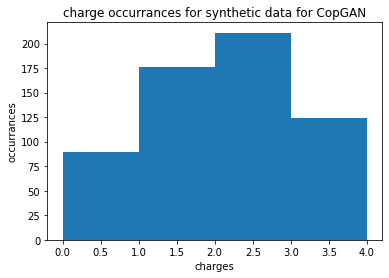

In [21]:
from matplotlib import pyplot as plt
#num_bins = 20
#group = [1000*i for i in range(13,65)]
#plt.hist(synth_data["charges"], group)
total01=len(synth_data["charges"])
ans01=[]
for i in range(0,65):
    num=len(synth_data["charges"][synth_data["charges"]==i])
    ans01.append(num/total01)
ans01=np.array(ans01)
print("The ratio of the synthetic data of charge >14000 is %.4f"%sum(ans01[14:]))
plt.title("charge occurrances for synthetic data for CopGAN")
plt.xlabel("charges")
plt.ylabel("occurrances")
plt.hist(synth_data["charges"],bins=[i for i in range (5)])

Now this data can be fed into a new `setup` but this time declaring `test_data` as the test data that was created earlier. 

So there is a combination of **synthetic and real data in the training set** but only real in the test data.

In [23]:
# Run pycaret setup w/synthetic data
setup(data = mixed, 
      target = target, 
      test_data = test,
      train_size = 0.7, 
      numeric_features = cont_feats,
      categorical_features = cat_feats,
      ordinal_features = ord_feats,
      normalize_method = "zscore",
      ignore_low_variance = True,
      silent = True, verbose = False)

(0      2
 1      2
 2      0
 3      0
 4      1
       ..
 595    3
 596    1
 597    2
 598    3
 599    2
 Name: charges, Length: 1402, dtype: int64,
 10,
 'charges',
 6689,
 [],
 'lightgbm',
       age        bmi  children  sex_male  smoker_no  region_northeast  \
 0    59.0  27.719999       3.0       0.0        1.0               0.0   
 1    60.0  25.740000       0.0       1.0        1.0               0.0   
 2    28.0  34.770000       0.0       0.0        1.0               0.0   
 3    19.0  28.400000       1.0       0.0        1.0               0.0   
 4    45.0  27.500000       3.0       1.0        1.0               0.0   
 ..    ...        ...       ...       ...        ...               ...   
 595  61.0  18.006292       1.0       1.0        1.0               1.0   
 596  34.0  18.993849       1.0       1.0        1.0               0.0   
 597  42.0  36.168514       4.0       1.0        1.0               0.0   
 598  64.0  43.046825       0.0       0.0        0.0            

In [24]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.5859,0.7523,0.5882,0.5875,0.5789,0.4414,0.4438,0.1380
ada,Ada Boost Classifier,0.5703,0.7302,0.5707,0.5753,0.5625,0.4205,0.4242,0.0300
rf,Random Forest Classifier,0.5632,0.7523,0.5673,0.5600,0.5568,0.4125,0.4146,0.1420
lightgbm,Light Gradient Boosting Machine,0.5574,0.7393,0.5606,0.5552,0.5506,0.4033,0.4056,0.0730
lr,Logistic Regression,0.5518,0.7309,0.5615,0.5537,0.5442,0.3974,0.4004,0.8080
lda,Linear Discriminant Analysis,0.5489,0.7308,0.5602,0.5499,0.5401,0.3940,0.3975,0.0110
ridge,Ridge Classifier,0.5354,0.0000,0.5479,0.5362,0.5235,0.3763,0.3811,0.0120
nb,Naive Bayes,0.5311,0.7284,0.5457,0.5437,0.5250,0.3726,0.3785,0.0130
et,Extra Trees Classifier,0.5269,0.7330,0.5293,0.5291,0.5230,0.3645,0.3669,0.1230
dt,Decision Tree Classifier,0.4656,0.6390,0.4712,0.4644,0.4618,0.2815,0.2829,0.0110


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=6689, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

A gradient boosting classifier was decided upon.

In [25]:
gbc = create_model("gbc")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8369,0.9392,0.8410,0.8413,0.8366,0.7806,0.7819
1,0.8794,0.9596,0.8733,0.8827,0.8798,0.8378,0.8385
2,0.7714,0.8663,0.7713,0.7780,0.7653,0.6925,0.6972
3,0.7929,0.9126,0.8019,0.8001,0.7894,0.7226,0.7263
4,0.7786,0.9208,0.7854,0.7778,0.7763,0.7034,0.7044
5,0.5286,0.7273,0.5564,0.5219,0.5155,0.3745,0.3794
6,0.4714,0.6824,0.4884,0.4853,0.4607,0.2893,0.2970
7,0.2714,0.5162,0.2587,0.2680,0.2519,0.0090,0.0095
8,0.2786,0.4971,0.2685,0.2795,0.2731,0.0210,0.0213
9,0.2500,0.5011,0.2375,0.2404,0.2407,-0.0172,-0.0175


# **Second round**
# **+data constaint, +uniform**
We will make the distribution uniform and see whether the result will be better.

In [26]:
best_score = 0 # Keep track of best score
# best_params=None
best_data = None
tracker = 0 # Keep track of how many loops have completed
flag = True
scores=[]

real = train # Filter to only those employees that left

import time
ST=time.time()

## TRAINING LOOP START ##
for _ in range(30): # only 1 and do the test

    # Increment the tracker
    tracker += 1
  
    # Every 5 loops output the tracker -> 1 loop
    print(tracker)



    # Record the hyperparameters and score      
    # proposal = tuner.propose(1)
  
    # NOTE - batch_size is multiplied by 10 as needs to be a factor of 10
    #model = GaussianCopula(constraints = [age_constraint, children_constraint, bmi_constraint, charges_constraint])
    model = CopulaGAN(constraints = [age_constraint, children_constraint, bmi_constraint])
    
    # Fit the CopulaGAN
    model.fit(real)
    # Create 600 rows of data
    synth_data = model.sample(num_rows = 1500)
  
    # Evaluate the synthetic data against the real data
    score = evaluate(synthetic_data = synth_data, real_data = real)
    scores.append(score)

    print(score)
    # If the new hyperparameters beat the best ones, store them along with the score
    if score > best_score or flag:
        flag = False
        best_data = synth_data
        best_distributions = model.get_distributions()
        # best_params = proposal
        best_score = score
  
    # Record the hyperparameters and score      
    # tuner.record(proposal, score)


## TRAINING LOOP END ##
ED=time.time()
print("time used: %.3f mins"%((ED-ST)/60))

1
0.48685794138800387
2
0.5187678323079957
3
0.5337305455048854
4
0.5193727257615344
5
0.5445805103778917
6
0.5810414301507945
7
0.5782324985446124
8
0.6087664861969722
9
0.5075163224561718
10
0.5680537938239762
11
0.5238442146433343
12
0.4859677320400032
13
0.5169709512283358
14
0.5522514482997569
15
0.5281422435096739
16
0.5520664958798311
17
0.5004497693367247
18
0.49912847531411825
19
0.5157977029382369
20
0.5597836232219972
21
0.5597190652521862
22
0.5835560698906485
23
0.5411866459595293
24
0.531773401088319
25
0.6162386410082523
26
0.5551616783021811
27
0.5620488187221229
28
0.5170235495227629
29
0.5615078346150075
30
0.4816629521644022
time used: 15.218 mins


In [27]:
best_data

,age,sex,bmi,children,smoker,region,charges
0,61,female,35.858174,3,yes,southwest,3
1,19,female,33.958227,0,yes,northeast,0
2,44,male,23.903996,3,no,southeast,1
3,19,male,24.128202,1,yes,southeast,0
4,28,male,14.376043,1,no,southwest,3
...,...,...,...,...,...,...,...
6,63,male,36.127624,2,yes,southwest,0
7,63,female,38.368572,3,yes,northwest,0
8,64,male,24.280545,4,yes,southeast,2
9,62,male,20.819275,1,no,southeast,1


In [28]:
best_distributions

{'age': 'copulas.univariate.beta.BetaUnivariate',
 'bmi': 'copulas.univariate.gamma.GammaUnivariate',
 'children': 'copulas.univariate.student_t.StudentTUnivariate',
 'charges': 'copulas.univariate.gaussian.GaussianUnivariate'}

(array([434., 418., 295., 342.]),
 array([0, 1, 2, 3, 4]),
 <a list of 4 Patch objects>)

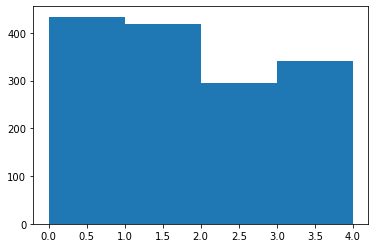

In [29]:
best=best_data
best_data=best_data[~best_data.index.duplicated()]
num_bins = 20
plt.hist(best_data["charges"], [i for i in range (5)])

In [30]:
score = evaluate(synthetic_data = best_data, real_data = real, aggregate = False)
score

,metric,name,raw_score,normalized_score,min_value,max_value,goal
0,BNLogLikelihood,BayesianNetwork Log Likelihood,-2.728505,6.531686e-02,-inf,0.0,MAXIMIZE
1,LogisticDetection,LogisticRegression Detection,0.806029,8.060290e-01,0.0,1.0,MAXIMIZE
2,SVCDetection,SVC Detection,0.365367,3.653671e-01,0.0,1.0,MAXIMIZE
11,GMLogLikelihood,GaussianMixture Log Likelihood,-457.684930,1.698089e-199,-inf,inf,MAXIMIZE
12,CSTest,Chi-Squared,0.931448,9.314480e-01,0.0,1.0,MAXIMIZE
13,KSTest,Inverted Kolmogorov-Smirnov D statistic,0.879612,8.796124e-01,0.0,1.0,MAXIMIZE
14,KSTestExtended,Inverted Kolmogorov-Smirnov D statistic,0.914713,9.147125e-01,0.0,1.0,MAXIMIZE
27,ContinuousKLDivergence,Continuous Kullback–Leibler Divergence,0.633010,6.330096e-01,0.0,1.0,MAXIMIZE
28,DiscreteKLDivergence,Discrete Kullback–Leibler Divergence,0.975047,9.750473e-01,0.0,1.0,MAXIMIZE


In [6]:
#Balancing the number in each catagory 
synth=[]
for i in range (4):
    orig_size=len(train[train["charges"]==i])
    synth_part=best_data[best_data["charges"]==i]
    generate=synth_part[:150]
    synth.append(generate)
synth=pd.concat(synth)
synth.sample(frac=1)

NameError: name 'best_data' is not defined

In [32]:
score = evaluate(synthetic_data = synth, real_data = train, aggregate = True)
score

0.6256067237834135

In [33]:
print('Best score obtained: ', best_score)

Best score obtained:  0.6162386410082523


In [34]:
print(max(scores))
print(min(scores))

0.6162386410082523
0.4816629521644022


In [35]:
model.save('best_copula.pkl')

In [36]:
synth.to_csv("ins_synth_data_classifier_CG_unif.csv", index = False)

Now we, again, see what happened when we add the synthetic data.

In [37]:
# Load synth data in
synth_data2 = pd.read_csv("ins_synth_data_classifier_CG_unif.csv")

# Add the 600 synthetic rows of data to training data + remove dataset column
mixed = pd.concat([train, synth_data2])

In [38]:
mixed

,age,sex,bmi,children,smoker,region,charges
0,59,female,27.720000,3,no,southeast,2
1,60,male,25.740000,0,no,southeast,2
2,28,female,34.770000,0,no,northwest,0
3,19,female,28.400000,1,no,southwest,0
4,45,male,27.500000,3,no,southwest,1
...,...,...,...,...,...,...,...
595,45,male,22.127109,1,no,southeast,3
596,55,male,24.641705,0,yes,southeast,3
597,18,female,30.592786,0,no,southwest,3
598,36,female,24.260795,3,yes,southwest,3


Now this data can be fed into a new `setup` but this time declaring `test_data` as the test data that was created earlier. 

So there is a combination of **synthetic and real data in the training set** but only real in the test data.

In [40]:
# Run pycaret setup w/synthetic data
setup(data = mixed, 
      target = "charges", 
      test_data = test,
      train_size = 0.7, 
      numeric_features = cont_feats,
      categorical_features = cat_feats,
      ordinal_features = ord_feats,
      normalize_method = "zscore",
      ignore_low_variance = True,
      silent = True, verbose = False)

(0      2
 1      2
 2      0
 3      0
 4      1
       ..
 595    3
 596    3
 597    3
 598    3
 599    3
 Name: charges, Length: 1402, dtype: int64,
 10,
 'charges',
 8132,
 [],
 'lightgbm',
       age        bmi  children  sex_female  smoker_no  region_northeast  \
 0    59.0  27.719999       3.0         1.0        1.0               0.0   
 1    60.0  25.740000       0.0         0.0        1.0               0.0   
 2    28.0  34.770000       0.0         1.0        1.0               0.0   
 3    19.0  28.400000       1.0         1.0        1.0               0.0   
 4    45.0  27.500000       3.0         0.0        1.0               0.0   
 ..    ...        ...       ...         ...        ...               ...   
 595  45.0  22.127110       1.0         0.0        1.0               0.0   
 596  55.0  24.641705       0.0         0.0        0.0               0.0   
 597  18.0  30.592787       0.0         1.0        1.0               0.0   
 598  36.0  24.260796       3.0         1.0 

Now setup the `compare_models` can be checked again. Interestingly the `AUC`, `Recall` and `Precision` all went up considerably. `Recall` nearly doubled!

In [41]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.5824,0.7520,0.5827,0.5881,0.5808,0.4433,0.4454,0.1380
ada,Ada Boost Classifier,0.5617,0.7279,0.5621,0.5694,0.5603,0.4159,0.4185,0.0330
rf,Random Forest Classifier,0.5575,0.7526,0.5574,0.5592,0.5556,0.4099,0.4109,0.1420
lightgbm,Light Gradient Boosting Machine,0.5368,0.7466,0.5370,0.5393,0.5356,0.3824,0.3832,0.0730
lda,Linear Discriminant Analysis,0.5289,0.7139,0.5296,0.5326,0.5247,0.3723,0.3743,0.0110
lr,Logistic Regression,0.5282,0.7139,0.5289,0.5309,0.5233,0.3713,0.3735,0.7200
et,Extra Trees Classifier,0.5276,0.7328,0.5276,0.5276,0.5250,0.3701,0.3711,0.1250
nb,Naive Bayes,0.5247,0.7157,0.5252,0.5299,0.5224,0.3666,0.3684,0.0120
ridge,Ridge Classifier,0.5204,0.0000,0.5213,0.5249,0.5108,0.3610,0.3661,0.0100
knn,K Neighbors Classifier,0.4541,0.6788,0.4555,0.4446,0.4380,0.2729,0.2776,0.2860


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=8132, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

A gradient boosting classifier was decided upon.

In [43]:
gbc = create_model("gbc")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8511,0.9511,0.8518,0.8512,0.8509,0.8014,0.8016
1,0.8511,0.9328,0.8513,0.8583,0.8514,0.8014,0.8033
2,0.7929,0.9186,0.7942,0.7999,0.7913,0.7240,0.7274
3,0.8143,0.9359,0.8143,0.8246,0.8111,0.7524,0.7566
4,0.8286,0.9220,0.8286,0.8462,0.8289,0.7714,0.7768
5,0.6571,0.8288,0.6570,0.6747,0.6577,0.5429,0.5483
6,0.2643,0.5286,0.2652,0.2655,0.2622,0.0196,0.0198
7,0.2929,0.5428,0.2938,0.2910,0.2903,0.0577,0.0579
8,0.2071,0.4588,0.2082,0.1985,0.2009,-0.0563,-0.0567
9,0.2643,0.5008,0.2630,0.2715,0.2635,0.0187,0.0189


# **Third round, +constriant, +uniform, also use GCPTuner**
# Warning: Please don't run this, or just ignore the followings until they solved the BTB problem.

With the tuner ready it's as simple as creating a training loop and then calling the tuner within the loop and feeding the hyperparameters into the CopulaGAN.

In [64]:
tuner = GCPTuner(Tunable({
          'epochs': hp.IntHyperParam(min = 80, max = 400),
          'batch_size' : hp.IntHyperParam(min = 20, max = 100),
          'embedding_dim' : hp.IntHyperParam(min = 20, max = 100),
          'gen' : hp.IntHyperParam(min = 20, max = 1000),
          'dim_gen' : hp.IntHyperParam(min = 20, max = 1000)
        }))

In [66]:
best_score = 0 # Keep track of best score
best_params=None
best_data = None
tracker = 0 # Keep track of how many loops have completed
flag = True
scores=[]

real = train # Filter to only those employees that left

import time
ST=time.time()

## TRAINING LOOP START ##
for _ in range(30): # only 1 and do the test

    # Increment the tracker
    tracker += 1
  
    # Every 5 loops output the tracker -> 1 loop
    print(tracker)

    # Get the hyperparameters for this loop
    proposal = tuner.propose(1)
    print(proposal)
  
    # NOTE - batch_size is multiplied by 10 as needs to be a factor of 10
    #model = GaussianCopula(constraints = [age_constraint, children_constraint, bmi_constraint, charges_constraint])
    model = CopulaGAN(embedding_dim = proposal['embedding_dim'],
                      generator_dim = (proposal['gen'], proposal['gen']),
                      discriminator_dim = (proposal['dim_gen'], proposal['dim_gen']),
                      batch_size = proposal['batch_size'] * 10,
                      epochs = proposal['epochs'])
    
    # Fit the CopulaGAN
    model.fit(real)
    # Create 600 rows of data
    synth_data = model.sample(num_rows = 1500)
  
    # Evaluate the synthetic data against the real data
    score = evaluate(synthetic_data = synth_data, real_data = real)
    scores.append(score)

    print(score)
    # If the new hyperparameters beat the best ones, store them along with the score
    if score > best_score or flag:
        flag = False
        best_data = synth_data
        best_distributions = model.get_distributions()
        best_params = proposal
        best_score = score
  
    # Record the hyperparameters and score      
    tuner.record(proposal, score) # or <-- Just try???


## TRAINING LOOP END ##
ED=time.time()
print("time used: %.3f mins"%((ED-ST)/60))

1
{'epochs': 361, 'batch_size': 100, 'embedding_dim': 30, 'gen': 685, 'dim_gen': 362}
0.5044788677573201
2
{'epochs': 199, 'batch_size': 28, 'embedding_dim': 74, 'gen': 114, 'dim_gen': 493}
0.5666065056957247
3
{'epochs': 163, 'batch_size': 57, 'embedding_dim': 37, 'gen': 36, 'dim_gen': 509}
0.6466053943903272
4
{'epochs': 124, 'batch_size': 49, 'embedding_dim': 52, 'gen': 684, 'dim_gen': 256}
0.39644404058402155
5
{'epochs': 208, 'batch_size': 85, 'embedding_dim': 42, 'gen': 59, 'dim_gen': 229}
0.6192474279547819
6
{'epochs': 136, 'batch_size': 57, 'embedding_dim': 32, 'gen': 31, 'dim_gen': 474}
0.6226125053504352
7


ValueError: Expected 1d array, got [[0.48492823 0.76440827]
 [0.48492823 0.76440827]
 [0.48492823 0.76440827]
 ...
 [0.48492823 0.76440827]
 [0.48492823 0.76440827]
 [0.48492823 0.76440827]].

In [87]:
best_data

,age,sex,bmi,children,smoker,region,charges
1,26,female,32.267589,1,no,southwest,0
3,61,female,27.553124,3,no,northwest,1
6,46,male,32.913421,1,no,northwest,2
7,64,male,29.682247,0,no,southwest,2
8,18,male,19.744240,1,no,northeast,1
...,...,...,...,...,...,...,...
1411,40,male,27.006543,0,no,northwest,0
0,49,male,28.128127,1,no,northwest,2
1,41,female,20.339631,0,no,southeast,0
2,44,female,25.868209,2,yes,southeast,1


In [88]:
best_distributions

{'age': 'copulas.univariate.beta.BetaUnivariate',
 'bmi': 'copulas.univariate.gamma.GammaUnivariate',
 'children': 'copulas.univariate.student_t.StudentTUnivariate',
 'charges': 'copulas.univariate.gaussian.GaussianUnivariate'}

(array([1117.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.]),
 array([    0,  2000,  4000,  6000,  8000, 10000, 12000, 14000, 16000,
        18000, 20000, 22000, 24000, 26000, 28000, 30000, 32000, 34000,
        36000, 38000, 40000, 42000, 44000, 46000, 48000, 50000, 52000,
        54000, 56000, 58000, 60000, 62000, 64000]),
 <a list of 32 Patch objects>)

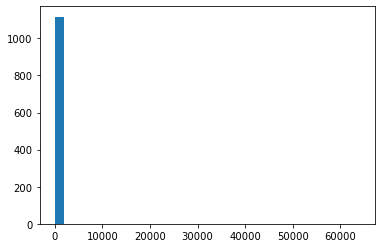

In [89]:
best=best_data
best_data=best_data[~best_data.index.duplicated()]
num_bins = 20
plt.hist(best_data["charges"], [2000*i for i in range (33)])

In [90]:
score = evaluate(synthetic_data = best_data, real_data = real, aggregate = False)
score

,metric,name,raw_score,normalized_score,min_value,max_value,goal
0,BNLogLikelihood,BayesianNetwork Log Likelihood,-2.598030,7.442001e-02,-inf,0.0,MAXIMIZE
1,LogisticDetection,LogisticRegression Detection,0.888730,8.887299e-01,0.0,1.0,MAXIMIZE
2,SVCDetection,SVC Detection,0.469880,4.698805e-01,0.0,1.0,MAXIMIZE
11,GMLogLikelihood,GaussianMixture Log Likelihood,-306.448010,8.153051e-134,-inf,inf,MAXIMIZE
12,CSTest,Chi-Squared,0.992152,9.921521e-01,0.0,1.0,MAXIMIZE
13,KSTest,Inverted Kolmogorov-Smirnov D statistic,0.927373,9.273727e-01,0.0,1.0,MAXIMIZE
14,KSTestExtended,Inverted Kolmogorov-Smirnov D statistic,0.953061,9.530615e-01,0.0,1.0,MAXIMIZE
27,ContinuousKLDivergence,Continuous Kullback–Leibler Divergence,0.744396,7.443961e-01,0.0,1.0,MAXIMIZE
28,DiscreteKLDivergence,Discrete Kullback–Leibler Divergence,0.997595,9.975952e-01,0.0,1.0,MAXIMIZE


In [91]:
print('Best score obtained: ', best_score)

Best score obtained:  0.6755951939804927


In [92]:
print(max(scores))
print(min(scores))

0.6755951939804927
0.46001404749117786


In [93]:
model.save('best_copula.pkl')

In [94]:
synth.to_csv("ins_synth_CG_norm_CF.csv", index = False)

# **Setting up data for round 2**
The real dataset can be split into 60:40 training/test. Once this has been split the synthetic data can be added to the training data. This in a way doesn't "waste" the real dataset in the training.

In [95]:
# Load synth data in
synth_data2 = pd.read_csv("ins_synth_CG_norm_CF.csv")

# Add the 600 synthetic rows of data to training data + remove dataset column
mixed = pd.concat([train, synth_data2])

In [96]:
mixed

,age,sex,bmi,children,smoker,region,charges
25,59,female,27.720000,3,no,southeast,2
336,60,male,25.740000,0,no,southeast,2
47,28,female,34.770000,0,no,northwest,0
106,19,female,28.400000,1,no,southwest,0
1269,45,male,27.500000,3,no,southwest,1
...,...,...,...,...,...,...,...
595,30,female,22.719581,1,no,northeast,3
596,24,male,30.782185,3,yes,southeast,3
597,61,male,29.781716,1,no,northwest,3
598,18,female,39.898391,0,no,northeast,3


In [97]:
print("Training size (real):", train.shape)
print("Training size (fake + real):", mixed.shape)
print("Testing size (real:", test.shape)

Training size (real): (802, 7)
Training size (fake + real): (1402, 7)
Testing size (real: (536, 7)


(array([1402.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.]),
 array([    0,  1000,  2000,  3000,  4000,  5000,  6000,  7000,  8000,
         9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000,
        18000, 19000, 20000, 21000, 22000, 23000, 24000, 25000, 26000,
        27000, 28000, 29000, 30000, 31000, 32000, 33000, 34000, 35000,
        36000, 37000, 38000, 39000, 40000, 41000, 42000, 43000, 44000,
        45000, 46000, 47000, 48000, 49000, 50000, 51000, 52000, 53000,
        54000, 55000, 56000, 57000, 58000, 59000, 60000, 610

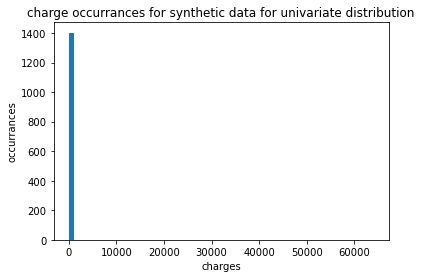

In [98]:
#plt.hist(synth_data["charges"], group)
total=len(mixed["charges"])
plt.title("charge occurrances for synthetic data for univariate distribution")
plt.xlabel("charges")
plt.ylabel("occurrances")
plt.hist(mixed["charges"], [1000*i for i in range (65)])

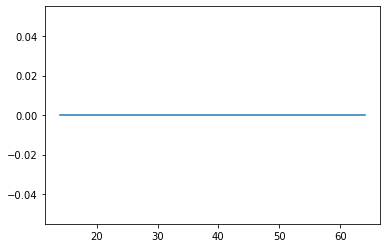

In [99]:
#plt.hist(ins_data["charges"][ins_data["charges"]>13000], group)
total2=len(ins_data["charges"][ins_data["charges"]>13000])
ans2 = []
for i in range(14,65):
    num=len(ins_data["charges"][ins_data["charges"]<(i+1)*1000][ins_data["charges"]>=i*1000])
    ans2.append(num/total)
ans2=np.array(ans2)
plt.plot(range(14,65),ans2)
plt.show()

Now this data can be fed into a new `setup` but this time declaring `test_data` as the test data that was created earlier. 

So there is a combination of **synthetic and real data in the training set** but only real in the test data.

In [100]:
# Run pycaret setup w/synthetic data
setup(data = mixed, 
      target = "charges", 
      test_data = test,
      train_size = 0.7, 
      numeric_features = cont_feats,
      categorical_features = cat_feats,
      ordinal_features = ord_feats,
      normalize_method = "zscore",
      ignore_low_variance = True,
      silent = True, verbose = False)

(False,
 False,
 'charges',
 None,
 'cb7c',
 'clf-default-name',
 764     1
 887     1
 890     3
 1293    2
 259     3
        ..
 588     2
 872     1
 914     1
 679     2
 256     3
 Name: charges, Length: 536, dtype: int64,
 False,
        age        bmi  children  sex_female  smoker_no  region_northeast  \
 25    59.0  27.719999       3.0         1.0        1.0               0.0   
 336   60.0  25.740000       0.0         0.0        1.0               0.0   
 47    28.0  34.770000       0.0         1.0        1.0               0.0   
 106   19.0  28.400000       1.0         1.0        1.0               0.0   
 1269  45.0  27.500000       3.0         0.0        1.0               0.0   
 ...    ...        ...       ...         ...        ...               ...   
 595   30.0  22.719582       1.0         1.0        1.0               1.0   
 596   24.0  30.782185       3.0         0.0        0.0               0.0   
 597   61.0  29.781715       1.0         0.0        1.0               

Now setup the `compare_models` can be checked again. Interestingly the `AUC`, `Recall` and `Precision` all went up considerably. `Recall` nearly doubled!

In [101]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.5853,0.7379,0.5857,0.5901,0.5833,0.4473,0.4490,0.0400
gbc,Gradient Boosting Classifier,0.5795,0.7501,0.5801,0.5785,0.5760,0.4397,0.4408,0.1540
rf,Random Forest Classifier,0.5575,0.7555,0.5577,0.5587,0.5547,0.4102,0.4112,0.1470
nb,Naive Bayes,0.5504,0.7391,0.5514,0.5575,0.5465,0.4013,0.4043,0.0150
lr,Logistic Regression,0.5482,0.7370,0.5491,0.5536,0.5438,0.3983,0.4005,0.5810
lda,Linear Discriminant Analysis,0.5468,0.7372,0.5477,0.5531,0.5429,0.3964,0.3985,0.0130
lightgbm,Light Gradient Boosting Machine,0.5411,0.7429,0.5415,0.5417,0.5383,0.3882,0.3895,0.0820
ridge,Ridge Classifier,0.5326,0.0000,0.5338,0.5381,0.5232,0.3776,0.3819,0.0130
et,Extra Trees Classifier,0.5318,0.7369,0.5318,0.5323,0.5291,0.3758,0.3771,0.1310
knn,K Neighbors Classifier,0.4513,0.6677,0.4529,0.4342,0.4281,0.2691,0.2749,0.2310


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=4722)

A gradient boosting classifier was decided upon.

In [141]:
par = create_model("par")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,10954.8805,143387712.5698,11974.4608,0.1995,0.9926,1.6671
1,9159.9032,103898711.5317,10193.0717,0.2458,0.8758,1.3109
2,8642.4571,98509753.0295,9925.2080,0.1533,0.8381,1.1994
3,6037.1063,98821511.4717,9940.9009,0.1665,0.6844,0.5700
4,5841.8495,122188292.2400,11053.8813,0.2626,0.6121,0.3460
5,7272.8044,130572913.1729,11426.8505,-0.0651,1.0492,0.6452
6,9428.8647,109644020.8651,10471.1041,-24.0453,1.4358,0.5739
7,11221.1583,160140846.3472,12654.6769,-28.1558,1.2325,0.4962
8,14925.8786,263586325.6491,16235.3419,-25.3092,0.7947,0.4559
9,24723.0391,677586546.7186,26030.4926,-15.9813,0.9026,0.5400
